In [19]:
%matplotlib inline

In [2]:
import numpy as np
import csv
from sklearn.cross_validation import cross_val_score
import matplotlib
from  matplotlib import pyplot as plt
# from sklearn import cross_validation
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn import metrics, preprocessing
import pickle

In [3]:
df = pd.read_csv("data.csv")

In [4]:
df.head(5)

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


In [19]:
x = pd.Series(df['eruptions'])
y = pd.Series(df['waiting'])

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


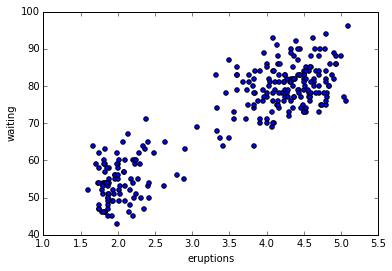

In [20]:
# pd.df.plot.scatter( x='eruptions', y='waiting')
df.plot(kind='scatter', x='eruptions', y='waiting')

In [36]:
# from sklearn.cross_validation import train_test_split
# train, test = train_test_split(df, test_size = 0.2)

In [60]:
from sklearn import datasets
from sklearn.mixture import GaussianMixture as gmix
from sklearn.model_selection import StratifiedKFold

In [38]:
# X = train.as_matrix()

In [39]:
# test = train.as_matrix()

In [49]:
X= df.as_matrix()

In [50]:
X[0:5]

array([[  3.6  ,  79.   ],
       [  1.8  ,  54.   ],
       [  3.333,  74.   ],
       [  2.283,  62.   ],
       [  4.533,  85.   ]])

In [61]:
model = gmix(2, max_iter=100,
                        covariance_type='spherical')

In [52]:
fittedGMM= model.fit(X)

In [53]:
AIC = model.aic(X)
BIC = model.bic(X)

In [54]:
AIC,BIC

(3433.0586604260725, 3458.2992748901443)

In [55]:
fittedGMM.score(X)

-6.28503430225381

In [56]:
fittedGMM

GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=2, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

In [33]:
print (fittedGMM.means)
# http://www.nehalemlabs.net/prototype/blog/2014/04/03/quick-introduction-to-gaussian-mixture-models-with-python/

AttributeError: 'GaussianMixture' object has no attribute 'means'

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


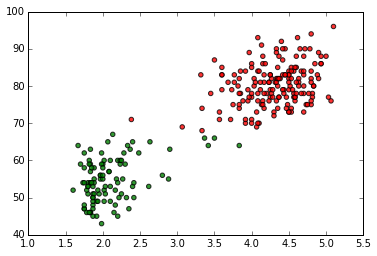

In [57]:
colors = ['r' if i==0 else 'g' for i in fittedGMM.predict(X)]
ax = plt.gca()
ax.scatter(X[:,0], X[:,1], c=colors, alpha=0.8)
plt.show()

In [18]:
# Compute GMM models & AIC/BIC
N = np.arange(1, 14)


def compute_GMM(N, covariance_type='full', n_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print (N[i])
        models[i] = GMM(n_components=N[i], max_iter=n_iter,
                        covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GMM(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print ("best fit converged:", gmm_best.converged_)
print ("BIC: n_components =  %i" % N[i_best])

# http://www.astroml.org/book_figures/chapter6/fig_EM_metallicity.html


1
2
3
4
5
6
7
8
9
10
11
12
13
best fit converged: True
BIC: n_components =  2


In [22]:
eruptions_bins = 51
waiting_bins = 51
H, eruptions_bins, waiting_bins = np.histogram2d(df['eruptions'], df['waiting'],
                                          (eruptions_bins, waiting_bins))

In [69]:
# For code below: looks like I could get access to the coordinates and to the iterations in the below method
# https://gist.github.com/bistaumanga/6023716

In [78]:

class GMM:
    
    def __init__(self, k = 3, eps = 0.0001):
        self.k = k ## number of clusters
        self.eps = eps ## threshold to stop `epsilon`
        
        # All parameters from fitting/learning are kept in a named tuple
        from collections import namedtuple
    
    def fit_EM(self, X, max_iters = 1000):
        
        # n = number of data-points, d = dimension of data points        
        n, d = X.shape
        
        # randomly choose the starting centroids/means 
        ## as 3 of the points from datasets        
        mu = X[np.random.choice(n, self.k, False), :]
        
        # initialize the covariance matrices for each gaussians
        Sigma= [np.eye(d)] * self.k
        print("Sigma", Sigma)
        
        # initialize the probabilities/weights for each gaussians
        w = [1./self.k] * self.k
        print ("W", w)
        
        # responsibility matrix is initialized to all zeros
        # we have responsibility for each of n points for eack of k gaussians
        R = np.zeros((n, self.k))
        print ("responsibility matrix", R)
        
        ### log_likelihoods
        log_likelihoods = []
        
        P = lambda mu, s: np.linalg.det(s) ** -.5 ** (2 * np.pi) ** (-X.shape[1]/2.) \
                * np.exp(-.5 * np.einsum('ij, ij -> i',\
                        X - mu, np.dot(np.linalg.inv(s) , (X - mu).T).T ) ) 
                        
        # Iterate till max_iters iterations        
        while len(log_likelihoods) < max_iters:
            
            # E - Step
            
            ## Vectorized implementation of e-step equation to calculate the 
            ## membership for each of k -gaussians
            for k in range(self.k):
                R[:, k] = w[k] * P(mu[k], Sigma[k])

            ### Likelihood computation
            log_likelihood = np.sum(np.log(np.sum(R, axis = 1)))
            print("log likelihood", log_likelihood)
            log_likelihoods.append(log_likelihood)
            
            
            ## Normalize so that the responsibility matrix is row stochastic
            R = (R.T / np.sum(R, axis = 1)).T
            
            ## The number of datapoints belonging to each gaussian            
            N_ks = np.sum(R, axis = 0)
            print ("num data points belonging to each guassian", N_ks)
            
            
            # M Step
            ## calculate the new mean and covariance for each gaussian by 
            ## utilizing the new responsibilities
            for k in range(self.k):
                
                ## means
                mu[k] = 1. / N_ks[k] * np.sum(R[:, k] * X.T, axis = 1).T
                x_mu = np.matrix(X - mu[k])
                
                ## covariances
                Sigma[k] = np.array(1 / N_ks[k] * np.dot(np.multiply(x_mu.T,  R[:, k]), x_mu))
                
                ## and finally the probabilities
                w[k] = 1. / n * N_ks[k]
            # check for onvergence
            if len(log_likelihoods) < 2 : continue
            if np.abs(log_likelihood - log_likelihoods[-2]) < self.eps: break
        
        ## bind all results together
        from collections import namedtuple
        self.params = namedtuple('params', ['mu', 'Sigma', 'w', 'log_likelihoods', 'num_iters'])
        self.params.mu = mu
        self.params.Sigma = Sigma
        self.params.w = w
        self.params.log_likelihoods = log_likelihoods
        self.params.num_iters = len(log_likelihoods)       
        
        print("self.params, " , self.params)
        return self.params
    
    def plot_log_likelihood(self):
        import pylab as plt
        plt.plot(self.params.log_likelihoods)
        plt.title('Log Likelihood vs iteration plot')
        plt.xlabel('Iterations')
        plt.ylabel('log likelihood')
        plt.show()
    
    def predict(self, x):
        p = lambda mu, s : np.linalg.det(s) ** - 0.5 * (2 * np.pi) **\
                (-len(x)/2) * np.exp( -0.5 * np.dot(x - mu , \
                        np.dot(np.linalg.inv(s) , x - mu)))
        probs = np.array([w * p(mu, s) for mu, s, w in \
            zip(self.params.mu, self.params.Sigma, self.params.w)])
        return probs/np.sum(probs)

In [79]:
gmm = GMM( )

In [80]:
gmm_fitted = gmm.fit_EM(X, max_iters = 1000)

Sigma [array([[ 1.,  0.],
       [ 0.,  1.]]), array([[ 1.,  0.],
       [ 0.,  1.]]), array([[ 1.,  0.],
       [ 0.,  1.]])]
W [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
responsibility matrix [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0

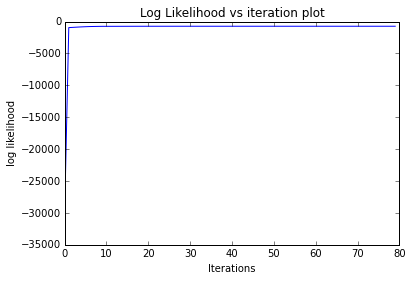

In [67]:
gmm.plot_log_likelihood()